In [1]:
import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from datasets import load_dataset

/Users/anurag/Desktop/Self/Coding Projects/financial-sentiment-analysis/fin-sen-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset
This dataset contains a collection of finance-related tweets labelled for sentiment classification. Each tweet is annotated as either positive, neutral, or negative, reflecting the tweet's tone in the context of financial markets. The data is sourced from public Twitter posts.

When using this dataset with Hugging Face models, predictions are returned in the format `LABEL_0`, `LABEL_1`, and `LABEL_2`. These model-generated labels correspond to the following sentiment classes:

```python
sentiments = {
    "LABEL_0": "Bearish",
    "LABEL_1": "Bullish",
    "LABEL_2": "Neutral"
}
```

This mapping allows model outputs to be interpreted in the context of market sentiment, where:
- `Bearish` indicates a negative or pessimistic outlook,
- `Bullish` indicates a positive or optimistic outlook, and
- `Neutral` reflects an informational or non-directional tone.

In [2]:
dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9543
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2388
    })
})

In [3]:
df = pd.DataFrame(dataset["train"])
df

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0
...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2
9539,Tupperware Brands among consumer gainers; Unil...,2
9540,vTv Therapeutics leads healthcare gainers; Myo...,2
9541,"WORK, XPO, PYX and AMKR among after hour movers",2


Straight away we can see that the labels are numerical, and the text associated seems to be slightly messy, and also have multiple ticker symbols. The first goal is to add more readability to the dataset.

## Sentiment Spreads

In [4]:
sentiments = {
    0: "bearish", 
    1: "bullish", 
    2: "neutral"
}  
df['label_str'] = df['label'].map(sentiments) # new column for readability

In [5]:
label_counts = df['label'].value_counts()
label_percentage = df['label'].value_counts(normalize=True) * 100.

print(label_counts.to_frame(), "\n\n", label_percentage.to_frame())

       count
label       
2       6178
1       1923
0       1442 

        proportion
label            
2       64.738552
1       20.150896
0       15.110552


## Frequency of classes
We can create a bar plot to obtain a visual of the spread of sentiments, even though above we can see that the neutral label makes up more than half the dataset.

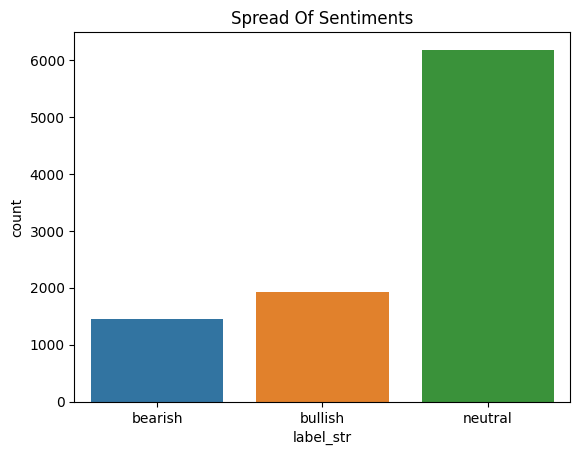

In [6]:
sns.countplot(x='label_str', data=df, hue='label_str', legend=False)
plt.title("Spread Of Sentiments")
plt.show()

We can see that the dataset is **heavily skewed** toward neutral tweets. Specifically, neutral labels make up around **65%** of the total data, which could lead to class imbalance issues during model training.

This imbalance may cause the model to favour the neutral class, so it'll be beneficial to consider **class weighting** and **resampling** as they might be necessary to improve performance on minority classes.

## Spreads of Data

### Tweet Length

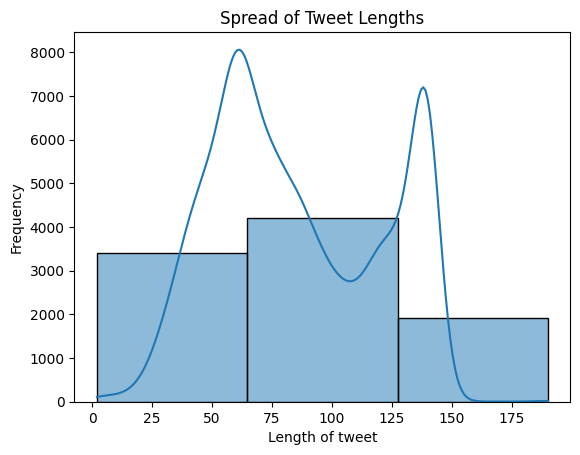

In [7]:
df['text_len'] = df['text'].apply(len)
sns.histplot(df['text_len'], bins=3, kde=True)
plt.xlabel("Length of tweet")
plt.ylabel("Frequency")
plt.title("Spread of Tweet Lengths")
plt.show()

While the histogram suggests that tweet lengths appear somewhat evenly distributed across the bins, the kernel density estimation (KDE) reveals a different pattern. Specifically, the KDE curve shows two distinct peaks—one around a tweet length of 60 and another near 130. This indicates that most tweets tend to cluster around these two lengths (±10 characters), suggesting a bimodal distribution rather than a uniform spread.

## Length of Tweet Sentiment

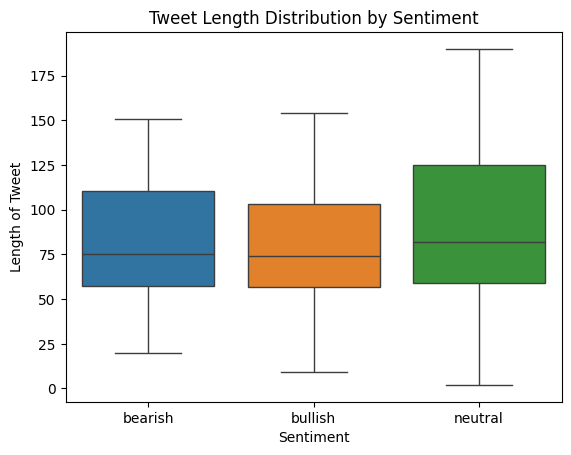

In [8]:
sns.boxplot(x='label_str', y='text_len', data=df, hue='label_str')
plt.title("Tweet Length Distribution by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Length of Tweet")
plt.show()

The boxplot shows that tweet lengths for bearish and bullish sentiments follow nearly identical distributions, with only a slight difference in their interquartile ranges—bearish tweets exhibit a marginal tendency toward longer lengths. However, this distinction is minimal. In contrast, neutral tweets display a significantly broader spread in length, even though their median is similar to the other sentiments. This wider variance is expected, given that neutral tweets comprise approximately 65% of the dataset, contributing to greater variability.

Additionally, the median tweet length remains consistent across all sentiment classes (roughly 75–80 characters), suggesting that tweet length alone is unlikely to serve as a strong feature for sentiment classification.

### Token Count Analysis
Given that we'll be creating vector embeddings for our tokenisation, it's crucial that we analyse the tokenisation frequency, this should allow us to decide our max token length when we do work with the model.

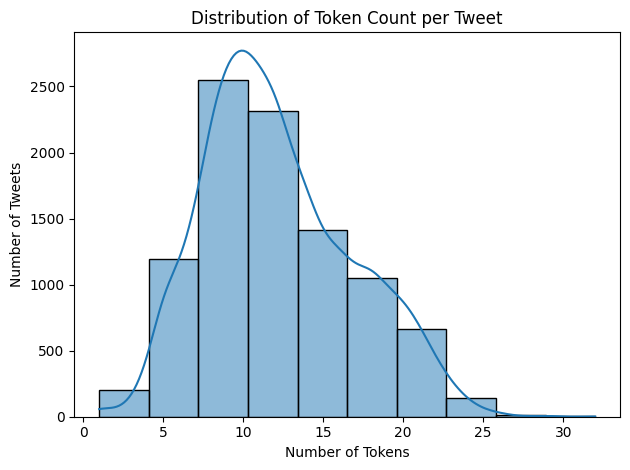

In [9]:
# Calculate token count per tweet
df['token_count'] = df['text'].apply(lambda x: len(x.split()))

sns.histplot(data=df, x='token_count', bins=10, kde=True)
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Token Count per Tweet")
plt.tight_layout()
plt.show()

In [10]:
df['token_count'].value_counts()

token_count
10    920
9     882
11    858
12    807
8     745
13    649
14    561
7     502
15    435
16    418
18    374
6     363
17    360
5     326
19    315
20    289
21    228
22    147
4     123
23     85
24     42
3      37
1      28
25     18
2      14
26     10
29      3
27      2
32      1
28      1
Name: count, dtype: int64

From the above distribution, we can see that most tweets fall between 5 and 15 tokens, with almost all under 30. So instead of using a large input length that adds unnecessary padding, we’ll keep max_length to 32 for training.

# Counting Word Frequency

In [16]:
# Combine all text into lone string - easier to scan everything in one go.
all_text = " ".join(df['text'].astype(str).tolist()).lower()

# Strip punctuation, eg. Profit. is identical to Profit
all_text = re.sub(r"[^\w\s]", "", all_text)

# Get the 30 most common words across the entire dataset
word_freq = Counter(all_text.split()).most_common(30)

# Convert to df for easier plotting
freq_df = pd.DataFrame(word_freq, columns=['word', 'count'])

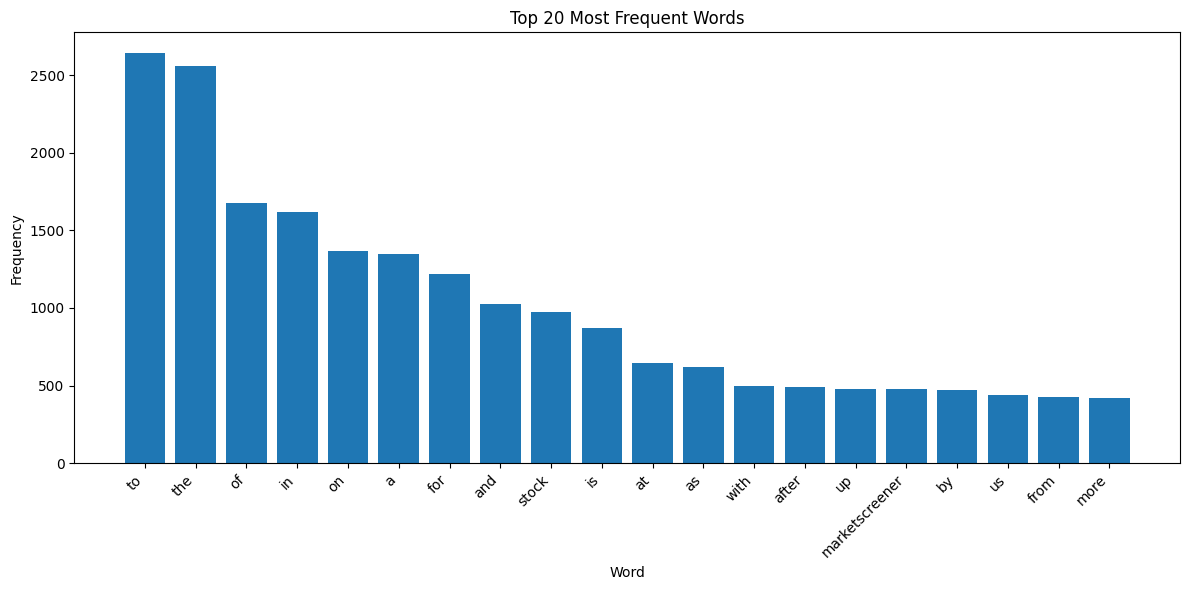

In [18]:
# Plot the top 20 most common words (currently includes stopwords)
plt.figure(figsize=(12, 6))
plt.bar(freq_df['word'].head(20), freq_df['count'].head(20))
plt.title("Top 20 Most Frequent Words")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The bar plot reveals the presence of several stop words that are unlikely to contribute meaningful information to model training. Therefore, it's advisable to remove these terms as part of the preprocessing pipeline. While common stopword lists from libraries like scikit-learn, NLTK, or spaCy are often used, we can also curate our own list based on the high-frequency terms identified in the plot above.

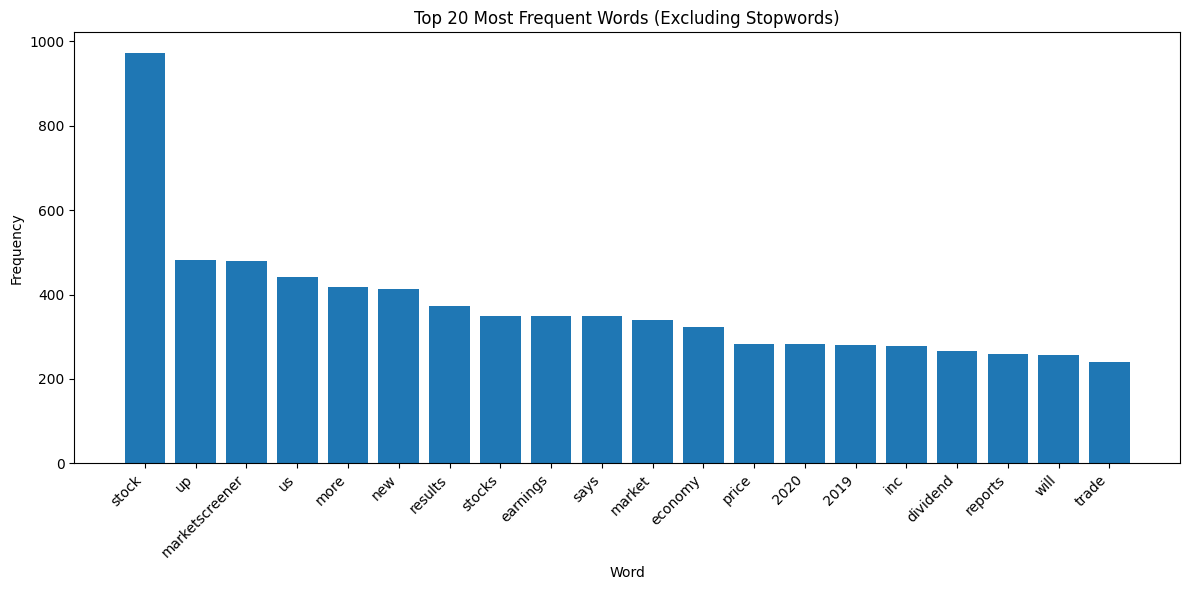

In [ ]:
# Custom stopwords tailored for this dataset, combining general-purpose noise words and domain-specific high-frequency terms.
# Identified based on EDA findings where these words carried minimal semantic weight for classification.
custom_stopwords = {
    'to', 'the', 'of', 'in', 'on', 'a', 'for', 'and', 'is', 'at', 'as', 'with', 'after', 'by', 'from',
    'are', 'its', 'this', 'that', 'it', 'was', 'has', 'have', 'be', 'been', 'an', 'or', 'but', 'not'
}

# Tokenise the cleaned text and remove stopwords
tokens = all_text.split()
filtered_tokens = [word for word in tokens if word not in custom_stopwords]

# Count top 50 frequent words
word_freq = Counter(filtered_tokens).most_common(20)
freq_df = pd.DataFrame(word_freq, columns=['word', 'count'])

# Plot the top 20 most common words (removes stopwords)
plt.figure(figsize=(12, 6))
plt.bar(freq_df['word'].head(20), freq_df['count'].head(20))
plt.title("Top 20 Most Frequent Words (Excluding Stopwords)")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


After filtering out common stopwords, the updated frequency chart gives us a much cleaner look at which words are actually showing up most often in the dataset. These terms are more likely to carry real signal and could actually help with downstream tasks like sentiment analysis. This step helps strip away noise and lets us focus on content that might actually matter to the model.

### 🔍 EDA Summary & Modeling Decisions

| **Insight from EDA**                                                                            | **Modeling Decision**                                                                 |
|--------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------|
| Most tweets are short, with the majority under 30 tokens                                         | Set `max_length = 32` to avoid unnecessary padding and improve efficiency             |
| Strong class imbalance — majority of tweets are **neutral**, fewer are **bullish** or **bearish**| Use `class_weights` during training to mitigate imbalance and improve F1 scores      |
| Tweet length distribution is similar across sentiments, but neutral tweets show more variance    | Avoid relying on length as a predictive feature, focus on textual content             |                              
| Token count KDE shows no heavy-tailed outliers                                                   | No need for extreme truncation as mentioned before; `max_length=32–64` is sufficient  |
| Minor difference in length distributions across sentiments                                       | Reinforces that text content matters more than length alone                           |



## Creating Dataset based on EDA

In [20]:
# Custom stopwords selected based on EDA — includes both generic filler words and high-frequency domain terms 
# that add little value for sentiment classification.
custom_stopwords = {
    'to', 'the', 'of', 'in', 'on', 'a', 'for', 'and', 'is', 'at', 'as', 'with', 'after', 'by', 'from',
    'are', 'its', 'this', 'that', 'it', 'was', 'has', 'have', 'be', 'been', 'an', 'or', 'but', 'not'
}

# Utility function to remove stopwords from a given string
def remove_stopwords(text: str, stopwords: set) -> str:
    """
    Removes stopwords from a given string.

    Args:
        text (str): Lowercased and punctuation-removed input text.
        stopwords (set): A set of stopwords to remove.

    Returns:
        str: Text with stopwords removed.
    """
    return " ".join([word for word in text.split() if word not in stopwords])


def clean_text(df: pd.DataFrame) -> None:
    """
    Cleans the text in the 'text' column of a DataFrame by:
    - Lowercasing the text
    - Removing URLs
    - Replacing repeated punctuation with a single instance
    - Removing punctuation (except $ for tickers)
    - Removing stopwords

    Args:
        df (pd.DataFrame): DataFrame containing a 'text' column to be cleaned.
    """
    url_pattern = r"http\S+|www\S+"
    repeated_punct_pattern = r"([!?.])\1+"
    punctuation_except_dollar = r"[^\w\s$]"  # preserves $

    df['text'] = (
        df['text']
        .astype(str)
        .apply(str.lower)  # Convert to lowercase
        .apply(lambda x: re.sub(url_pattern, "[URL]", x))  # Remove URLs
        .apply(lambda x: re.sub(repeated_punct_pattern, r"\1", x))  # Collapse repeated punctuation
        .apply(lambda x: re.sub(punctuation_except_dollar, "", x))  # Remove punctuation except $
        .apply(lambda x: remove_stopwords(x, custom_stopwords))  # Remove stopwords
    )

In [23]:
# Clean text associated with training and testing dataframe
df = pd.DataFrame(dataset["train"])
df_val = pd.DataFrame(dataset["validation"])

clean_text(df)
clean_text(df_val)

# Create folder to store cleaned datasets
os.makedirs("../cleaned_datasets", exist_ok=True)

# Save cleaned train and test sets as CSVs
df.to_csv("../cleaned_datasets/cleaned_train.csv", index=False)
df_val.to_csv("../cleaned_datasets/cleaned_validation.csv", index=False)